# Exploration of factors influencing students’ PISA scores in Singapore with Machine Learning approaches : Classification Models 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import xgboost as xg 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression


# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report

#interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import RegressionPerf
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

# Feature Importance 
import shap

In [2]:
#Import datasets
train_singapore = pd.read_csv('datasets/train_pisa2018_singapore.csv')
test_singapore = pd.read_csv('datasets/test_pisa2018_singapore.csv')

In [3]:
train_singapore.head(2)

CNTSTUID  GRADE    AGE         ISCEDL  PARED  HISEI   IMMIG  \
0  70201292.0    0.0  15.75  ISCED level 3   13.0  73.91  Native   
1  70206843.0    0.0  16.00  ISCED level 3   16.0  65.12  Native   

                    REPEAT  MMINS  LMINS  ...  ICTCLASS  ICTOUTSIDE  WVARSTRR  \
0  Did not repeat a  grade  225.0  135.0  ...    0.2379      0.3583      52.0   
1  Did not repeat a  grade  315.0  385.0  ...   -0.2254     -0.6237       7.0   

   GENDER      MATH   SCIENCE      READ  TOTALSCORE  Is_MISCED_5A,6  \
0       1  634.0078  603.2218  674.4429  637.224167               0   
1       1  686.3560  682.3456  708.6816  692.461067               0   

   Is_FISCED_5A,6  
0               0  
1               1  

[2 rows x 68 columns]

In [4]:
test_singapore.head(2)

CNTSTUID  GRADE    AGE         ISCEDL  PARED  HISEI   IMMIG  \
0  70202942.0    0.0  16.00  ISCED level 3   11.0  75.54  Native   
1  70206829.0   -1.0  15.83  ISCED level 3   11.0  29.81  Native   

                    REPEAT  MMINS  LMINS  ...  ICTCLASS  ICTOUTSIDE  WVARSTRR  \
0  Did not repeat a  grade  200.0  160.0  ...    1.0418      1.3503       4.0   
1        Repeated a  grade  300.0  210.0  ...    0.0733      0.7719      71.0   

   GENDER      MATH   SCIENCE      READ  TOTALSCORE  Is_MISCED_5A,6  \
0       0  545.0969  456.2449  425.9418    475.7612               0   
1       1  581.2635  592.3786  569.7755    581.1392               0   

   Is_FISCED_5A,6  
0               0  
1               0  

[2 rows x 68 columns]

In [5]:
#Check for missing values
train_singapore.isnull().sum().sum(), test_singapore.isnull().sum().sum()

(0, 0)

In [6]:
#Set 'CNTSTUID' as index
train_singapore.set_index('CNTSTUID', inplace=True)
test_singapore.set_index('CNTSTUID', inplace=True)

In [7]:
train_singapore[['TOTALSCORE']].describe()

TOTALSCORE
count  5274.000000
mean    558.157485
std      92.696588
min     232.334533
25%     497.631708
50%     568.097283
75%     627.357517
max     784.566967

## Creating target variable

Classify students' performance level based on their Pisa total score. 
OECD classify student's performance level into 6 levels.
Higher than 707.93 ==> level 6
633.33-707.93 ==> level 5
558.73 - 633.33 ==> level 4
484.14 - 558.73 ==> level 3
409.54 - 484.14 ==> level 2
lower than 409.54  ==> level 1

In this analysis, student's perfomance are classified into two groups, level 3 and above or level 2 and below. 

In [29]:
# Create funtion to classify student's performance
def assign_performance_level(data):
    if data <= 558.73:
        return '0' #lowperformance 
    else:
         return '1'  #highperformance 

In [30]:
#Apply function to data
train_singapore['PISALEVEL'] = train_singapore['TOTALSCORE'].apply(assign_performance_level)
test_singapore['PISALEVEL'] = test_singapore['TOTALSCORE'].apply(assign_performance_level)

In [31]:
#Check target distribution
train_singapore['PISALEVEL'].value_counts()

1    2850
0    2424
Name: PISALEVEL, dtype: int64

In [32]:
#Check target distribution
train_singapore['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

1    54.04
0    45.96
Name: PISALEVEL, dtype: float64

In [33]:
#Check target distribution
test_singapore['PISALEVEL'].value_counts()

1    692
0    644
Name: PISALEVEL, dtype: int64

In [34]:
#Check target distribution
test_singapore['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

1    51.8
0    48.2
Name: PISALEVEL, dtype: float64

# Building Classification Models

In [35]:
# X and y are defined as same as regression model from previous study

In [36]:
X_train =train_singapore[['PARED', 'HISEI', 'LMINS', 'SMINS', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'HEDRES', 'ICTRES', 'DISCLIMA', 'JOYREAD',
       'SCREADCOMP', 'SCREADDIFF', 'PISADIFF', 'GCSELFEFF', 'RESPECT','AWACOM',
       'Is_MISCED_5A,6', 'Is_FISCED_5A,6', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_train = pd.get_dummies(columns=['Is_MISCED_5A,6', 'Is_FISCED_5A,6', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_train)
y_train = train_singapore['PISALEVEL']


X_test =test_singapore[['PARED', 'HISEI', 'LMINS', 'SMINS', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'HEDRES', 'ICTRES', 'DISCLIMA', 'JOYREAD',
       'SCREADCOMP', 'SCREADDIFF', 'PISADIFF', 'GCSELFEFF', 'RESPECT','AWACOM',
       'Is_MISCED_5A,6', 'Is_FISCED_5A,6', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_test = pd.get_dummies(columns=['Is_MISCED_5A,6', 'Is_FISCED_5A,6', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_test)
y_test = test_singapore['PISALEVEL']

## Dummy Classifier model

In [37]:
#Standardize data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

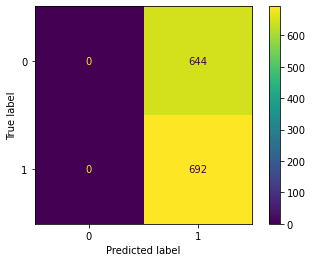

In [38]:
from sklearn.dummy import DummyClassifier
baseline_model = DummyClassifier()
baseline_model.fit(X_train_sc, y_train)
baseline_preds = baseline_model.predict(X_test_sc)
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds);

In [40]:
import warnings
warnings.filterwarnings("ignore")
print(classification_report(y_test, baseline_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       644
           1       0.52      1.00      0.68       692

    accuracy                           0.52      1336
   macro avg       0.26      0.50      0.34      1336
weighted avg       0.27      0.52      0.35      1336



## Logistic Regression

In [41]:
logreg =LogisticRegression()


parameters = [{'penalty':['none','l2']}, 
              {'C':[1, 10, 100]}]

logreg_gr = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

logreg_gr.fit(X_train_sc, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['none', 'l2']}, {'C': [1, 10, 100]}],
             scoring='accuracy')

In [42]:
preds= logreg_gr.predict(X_test_sc)

In [43]:
pd.DataFrame(logreg_gr.cv_results_).sort_values('rank_test_score').head(5)[['params','mean_test_score']]

params  mean_test_score
0  {'penalty': 'none'}         0.803944
3            {'C': 10}         0.803754
4           {'C': 100}         0.803754
1    {'penalty': 'l2'}         0.803564
2             {'C': 1}         0.803564

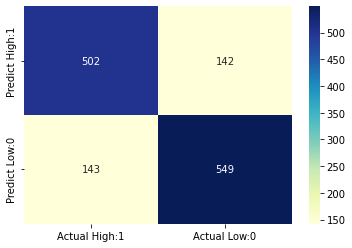

In [44]:
cm = confusion_matrix(y_test, preds)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [45]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       644
           1       0.79      0.79      0.79       692

    accuracy                           0.79      1336
   macro avg       0.79      0.79      0.79      1336
weighted avg       0.79      0.79      0.79      1336



In [46]:
#Get LogisticRegression
logreg =LogisticRegression(random_state= 42,)
logreg.fit(X_train_sc, y_train)
preds= logreg.predict(X_test_sc)
pd.Series(logreg.coef_[0], index = X_train.columns).sort_values(ascending=False)

METASPAM                    0.711851
SMINS                       0.685030
METASUM                     0.384178
JOYREAD                     0.359728
ESCS                        0.255850
UNDREM                      0.194375
GCSELFEFF                   0.188572
DISCLIMA                    0.152043
HEDRES                      0.131258
IMMIG_Second-Generation     0.119996
AWACOM                      0.115284
ICTRES                      0.058702
PARED                       0.057272
Is_MISCED_5A,6_1            0.047000
ISCEDL_ISCED level 3        0.039699
Is_FISCED_5A,6_1            0.021002
SCREADDIFF                  0.017225
IMMIG_Native                0.015243
HOMEPOS                     0.003183
HISEI                       0.001929
RESPECT                    -0.013738
ISCEDL_ISCED level 4       -0.053745
SCREADCOMP                 -0.191395
REPEAT_Repeated a  grade   -0.219008
GENDER_1                   -0.307232
PISADIFF                   -0.530056
LMINS                      -0.821781
d

In [47]:
# coefficient dataframe
logreg_coef = pd.DataFrame(data=logreg.coef_,columns=X_train.columns).T.sort_values(by=0,ascending=False)

# Label the color the each coefficient
color = ['red' if x < 0 else 'blue' for x in logreg_coef[0]]

# Assign the color_list to new column
logreg_coef['color'] = color

logreg_coef.head()

0 color
METASPAM  0.711851  blue
SMINS     0.685030  blue
METASUM   0.384178  blue
JOYREAD   0.359728  blue
ESCS      0.255850  blue

In [48]:
# Select the highest values whether negative or positive
abs(logreg_coef[0]).sort_values(ascending=False)[:10].index

Index(['LMINS', 'METASPAM', 'SMINS', 'PISADIFF', 'METASUM', 'JOYREAD',
       'GENDER_1', 'ESCS', 'REPEAT_Repeated a  grade', 'UNDREM'],
      dtype='object')

Text(0.5, 1.0, 'Top 10 highest coefficient')

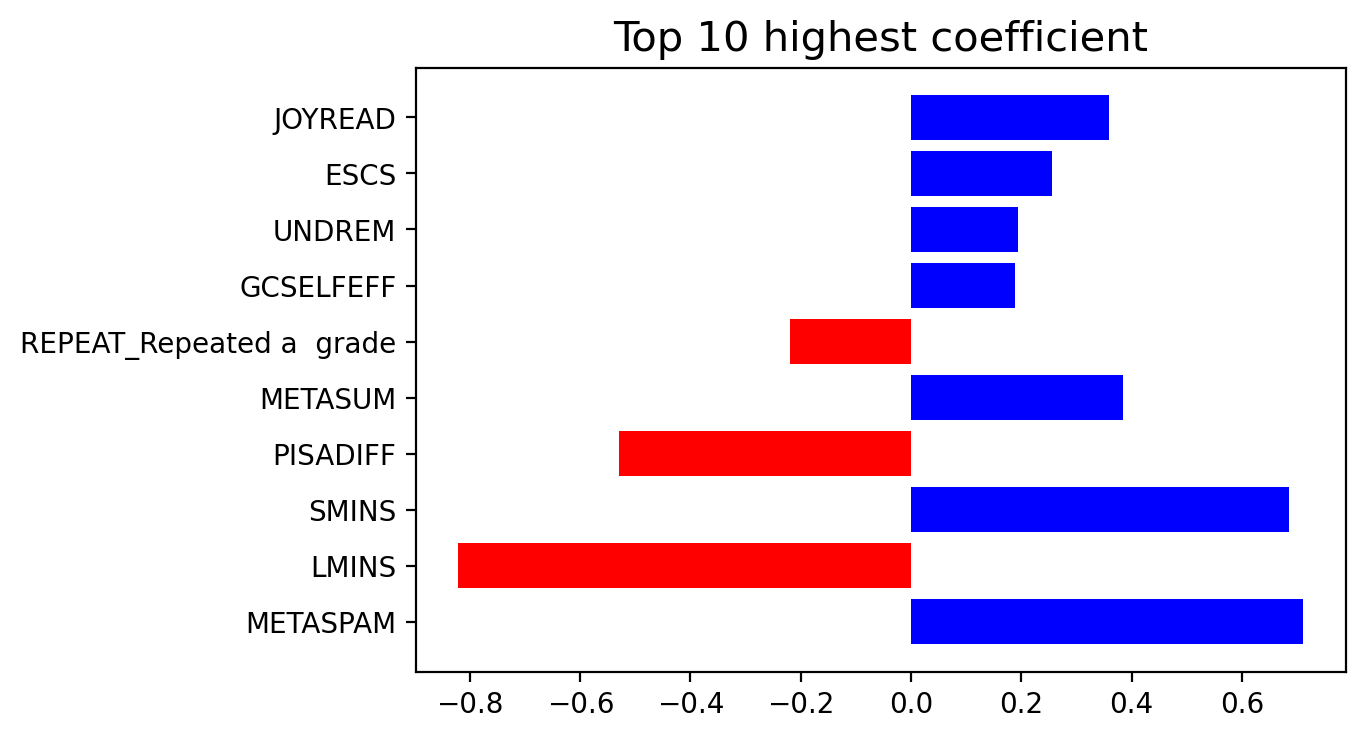

In [49]:
# Plot the coefficient of top 10 highest coefficient 
plt.figure(dpi=200)
plt.barh(logreg_coef.loc[['METASPAM', 'LMINS', 'SMINS', 'PISADIFF', 'METASUM',
       'REPEAT_Repeated a  grade', 'GCSELFEFF', 'UNDREM', 'ESCS', 'JOYREAD']].index,logreg_coef.loc[['METASPAM', 'LMINS', 'SMINS', 'PISADIFF', 'METASUM',
       'REPEAT_Repeated a  grade', 'GCSELFEFF', 'UNDREM', 'ESCS', 'JOYREAD']][0],color=logreg_coef.loc[['METASPAM', 'LMINS', 'SMINS', 'PISADIFF', 'METASUM',
       'REPEAT_Repeated a  grade', 'GCSELFEFF', 'UNDREM', 'ESCS', 'JOYREAD']]['color'])
plt.title('Top 10 highest coefficient',size=15)

## Explainable Boosting Classifier model

In [50]:
ebm = ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['PARED', 'HISEI', 'LMINS', 'SMINS',
                                             'ESCS', 'UNDREM', 'METASUM',
                                             'METASPAM', 'HOMEPOS', 'HEDRES',
                                             'ICTRES', 'DISCLIMA', 'JOYREAD',
                                             'SCREADCOMP', 'SCREADDIFF',
                                             'PISADIFF', 'GCSELFEFF', 'RESPECT',
                                             'AWACOM', 'Is_MISCED_5A,6_1',
                                             'Is_FISCED_5A,6_1',
                                             'ISCEDL_ISCED level 3',
                                             'ISCEDL_ISCED level 4',
                                             'IMMIG_Native',
                                             'IMMIG_Second-Generation...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'interaction',
                                             'interaction', 'interaction', ...])

In [51]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

In [52]:
ebm.score(X_train, y_train),ebm.score(X_test, y_test)

(0.8450891164201745, 0.7896706586826348)

In [53]:
preds_ebm = ebm.predict(X_test)

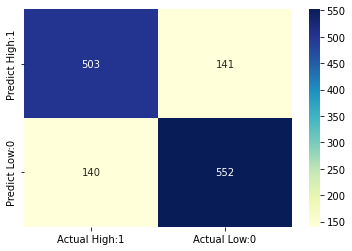

In [54]:
cm_ebm = confusion_matrix(y_test, preds_ebm)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [56]:
print(classification_report(y_test, preds_ebm))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       644
           1       0.80      0.80      0.80       692

    accuracy                           0.79      1336
   macro avg       0.79      0.79      0.79      1336
weighted avg       0.79      0.79      0.79      1336



## Random Forest Classifier Model

In [57]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set

rfc.fit(X_train, y_train)

# Predict on the test set results

preds_rfc = rfc.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. 
      format(accuracy_score(y_test, preds)))

Model accuracy score with 100 decision-trees : 0.7867


In [58]:
#Find important features with Random Forest model 

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

METASPAM                    0.118365
LMINS                       0.082654
ESCS                        0.077882
METASUM                     0.072492
SMINS                       0.068643
PISADIFF                    0.066598
JOYREAD                     0.060154
HOMEPOS                     0.059389
GCSELFEFF                   0.045049
DISCLIMA                    0.043069
ICTRES                      0.037571
AWACOM                      0.036844
SCREADDIFF                  0.036386
UNDREM                      0.034654
HISEI                       0.031231
SCREADCOMP                  0.028412
HEDRES                      0.028047
RESPECT                     0.020894
PARED                       0.015466
GENDER_1                    0.008630
Is_FISCED_5A,6_1            0.007054
IMMIG_Native                0.005421
Is_MISCED_5A,6_1            0.005219
REPEAT_Repeated a  grade    0.004343
IMMIG_Second-Generation     0.004337
ISCEDL_ISCED level 3        0.001019
ISCEDL_ISCED level 4        0.000177
d

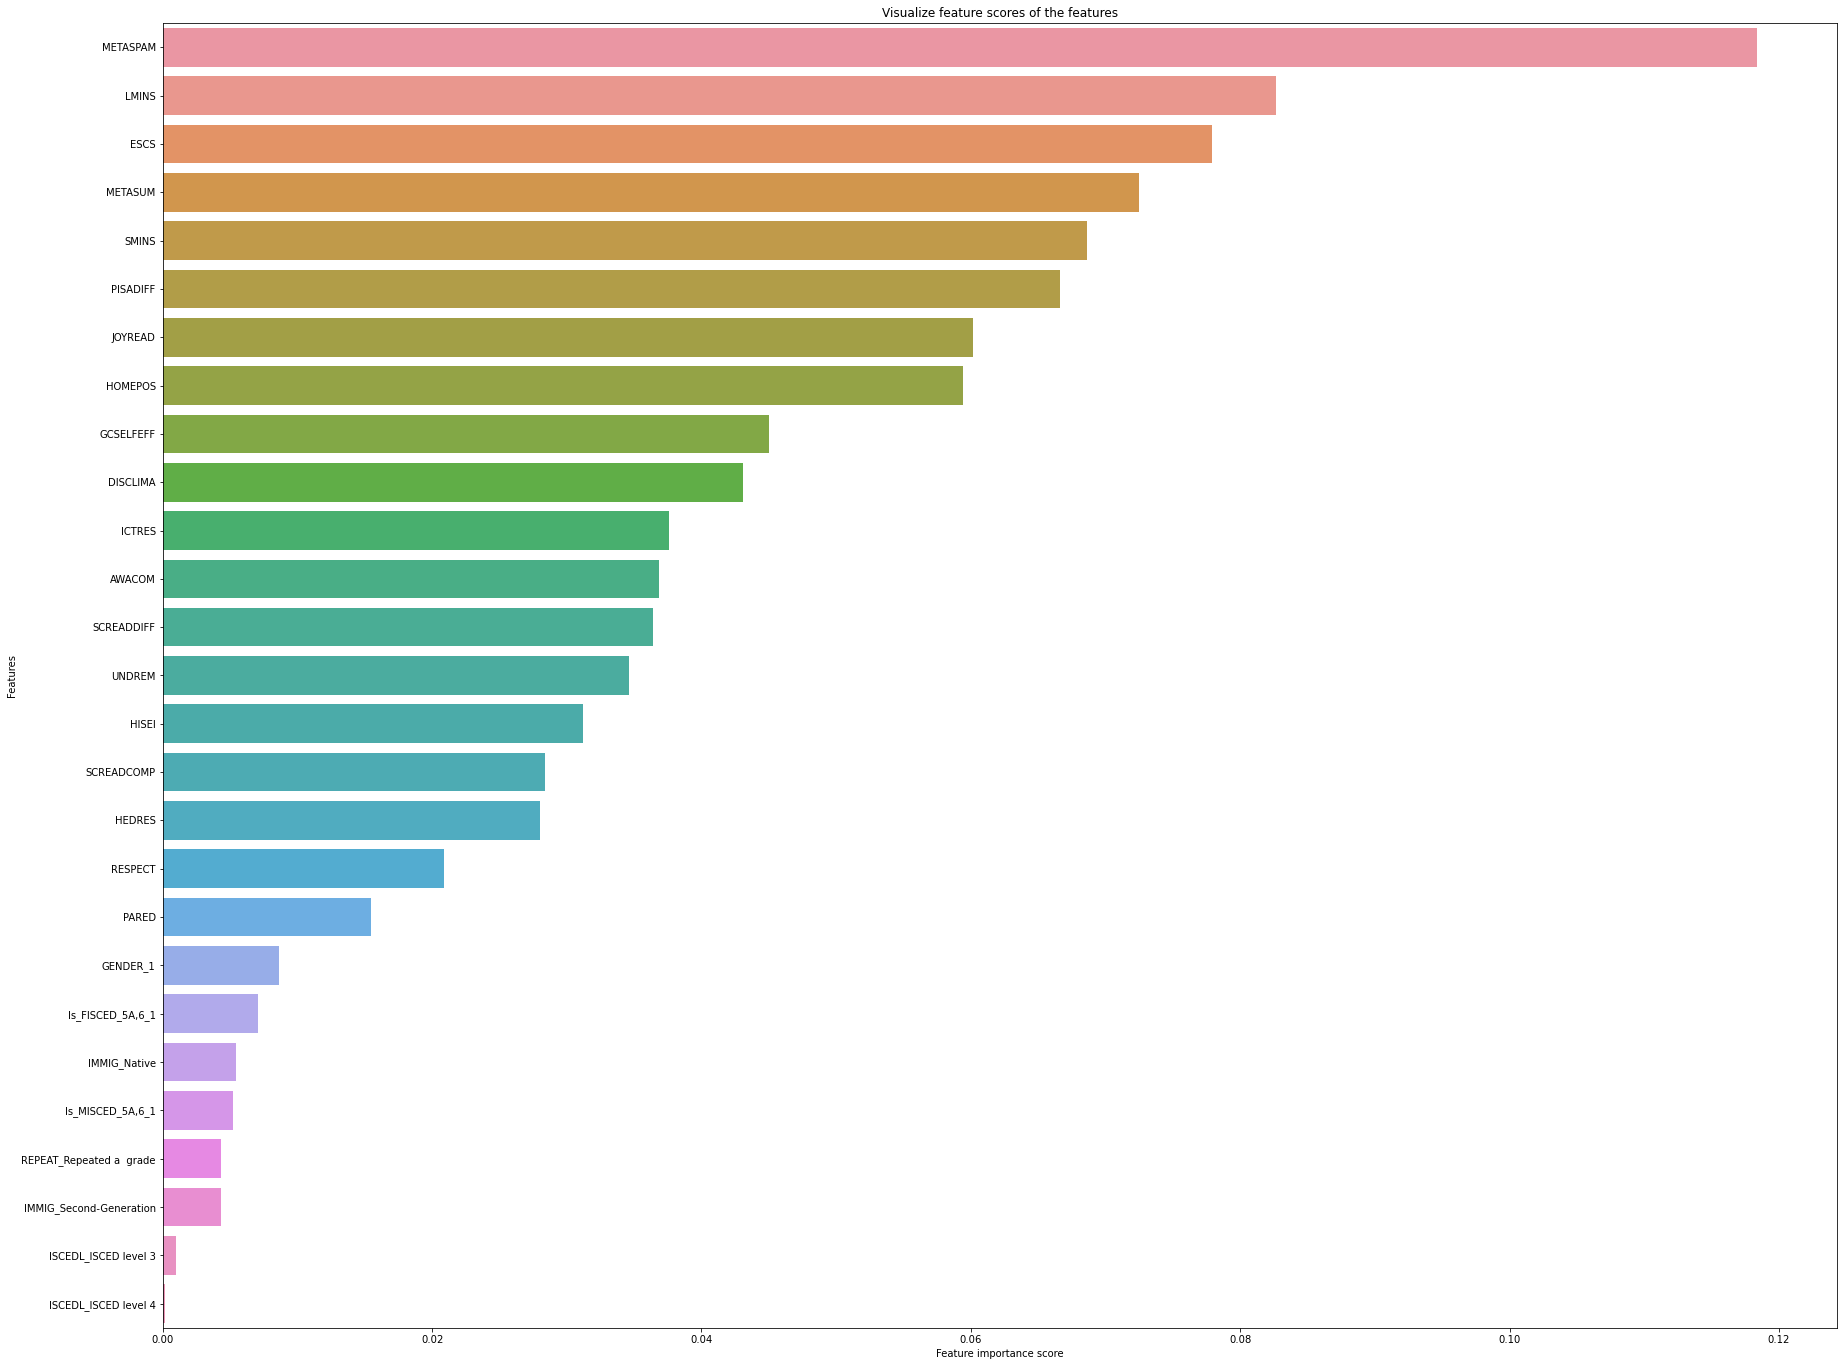

In [61]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=train_singapore)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

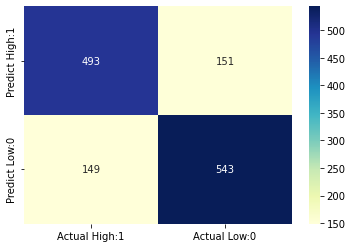

In [62]:
cm_rfc = confusion_matrix(y_test, preds_rfc)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_rfc, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [63]:
print(classification_report(y_test, preds_rfc))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       644
           1       0.78      0.78      0.78       692

    accuracy                           0.78      1336
   macro avg       0.78      0.78      0.78      1336
weighted avg       0.78      0.78      0.78      1336



# XGB Classifier model

In [64]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [65]:
xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 4)
xgb.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [66]:
preds_xgb = xgb.predict(X_test_sc)

In [67]:
# view the feature scores

feature_scores = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

METASPAM                    0.254929
PISADIFF                    0.087333
METASUM                     0.060608
REPEAT_Repeated a  grade    0.056483
LMINS                       0.049639
SMINS                       0.047150
GENDER_1                    0.033360
ESCS                        0.030432
Is_FISCED_5A,6_1            0.028455
JOYREAD                     0.027618
Is_MISCED_5A,6_1            0.027574
PARED                       0.025991
UNDREM                      0.025392
HOMEPOS                     0.024220
IMMIG_Native                0.022798
IMMIG_Second-Generation     0.022105
AWACOM                      0.021925
DISCLIMA                    0.021539
GCSELFEFF                   0.021367
SCREADCOMP                  0.020533
HISEI                       0.019384
ICTRES                      0.019035
RESPECT                     0.018003
SCREADDIFF                  0.017671
HEDRES                      0.016455
ISCEDL_ISCED level 3        0.000000
ISCEDL_ISCED level 4        0.000000
d

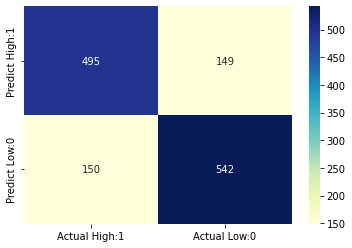

In [68]:
cm_xgb = confusion_matrix(y_test, preds_xgb)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_xgb, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [69]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       644
           1       0.78      0.78      0.78       692

    accuracy                           0.78      1336
   macro avg       0.78      0.78      0.78      1336
weighted avg       0.78      0.78      0.78      1336



In [70]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_sc)

In [71]:
shap_values

array([[-3.8718205e-02,  2.4293667e-01,  2.9959755e+00, ...,
        -6.8914726e-02,  6.1762735e-02, -5.3571266e-01],
       [ 2.9311432e-02, -3.1069478e-01, -1.3505318e+00, ...,
        -4.5010500e-02,  4.3811359e-02, -6.0705119e-01],
       [ 8.3279901e-04,  1.5768984e-01,  1.5481532e-01, ...,
        -3.8745593e-02,  5.4516505e-02, -6.1143881e-01],
       ...,
       [ 5.5255175e-02, -1.4618504e-01,  1.0634798e+00, ...,
        -6.5622814e-02,  4.4625591e-02, -3.9718506e-01],
       [-3.2592535e-02, -2.0051460e-01,  2.0723243e+00, ...,
         9.9071395e-01,  4.0831119e-02, -4.7347638e-01],
       [ 6.0959220e-02,  7.1938835e-02, -5.4118831e-02, ...,
        -5.0135311e-02,  6.8601556e-02,  4.6749312e-01]], dtype=float32)

In [72]:
#Local explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[0,:])

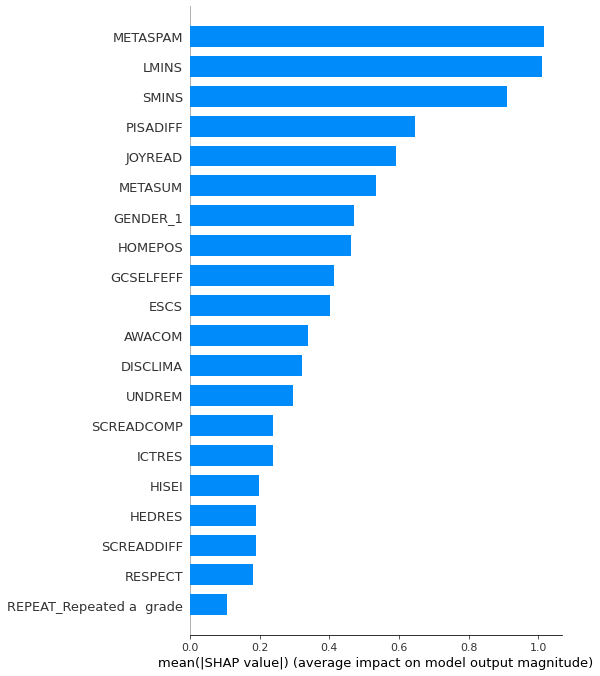

In [73]:
shap.summary_plot(shap_values, X_train_sc, plot_type="bar", feature_names= X_train.columns)

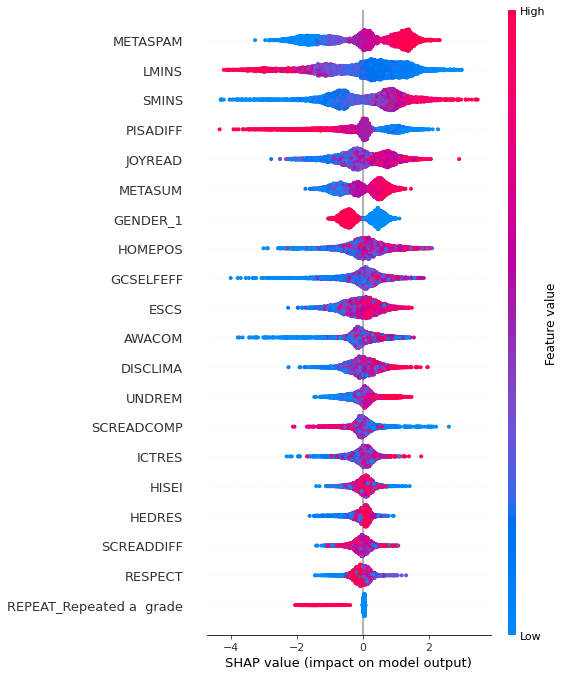

In [74]:
shap.summary_plot(shap_values, X_train)

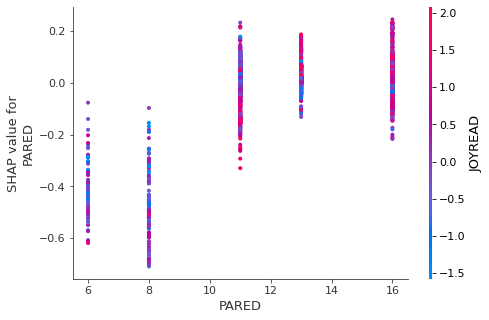

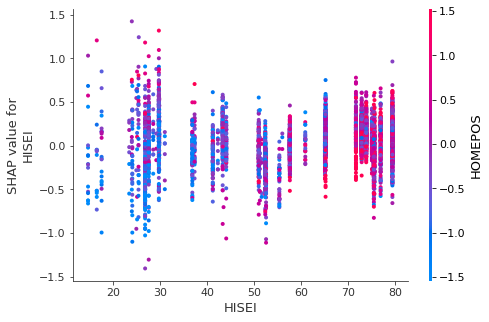

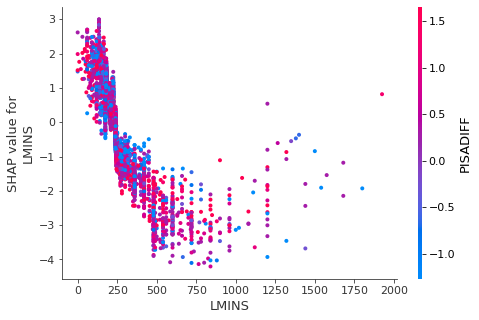

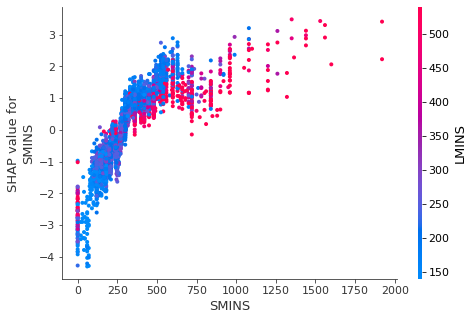

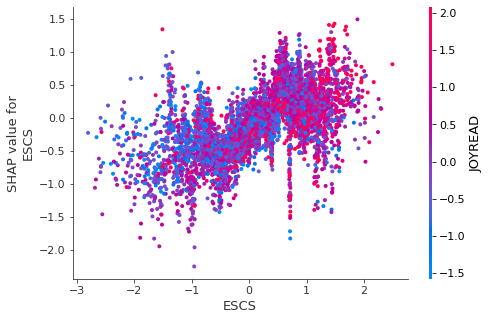

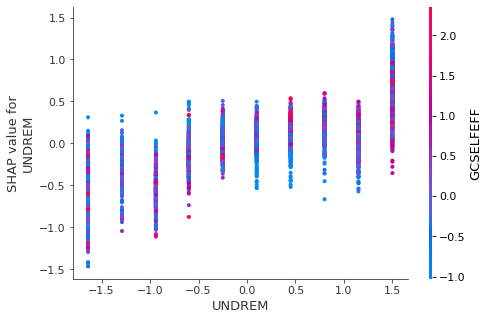

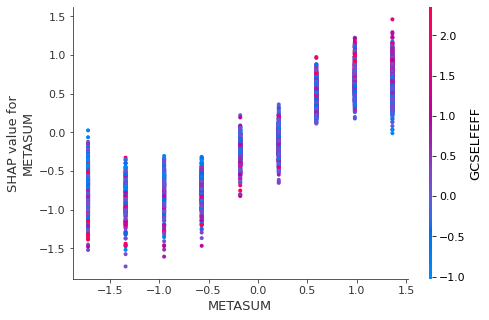

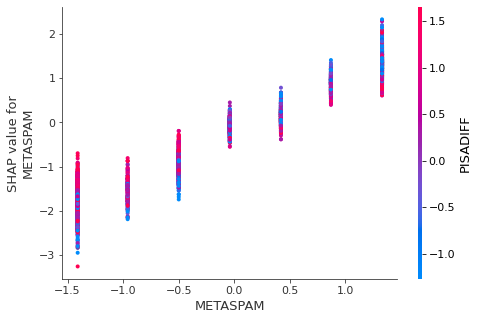

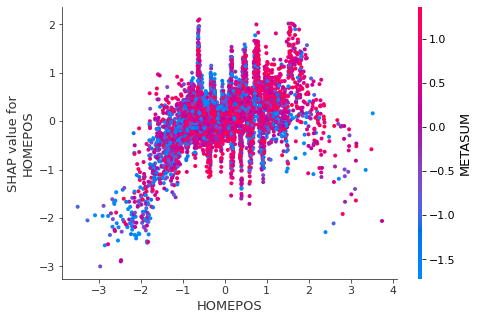

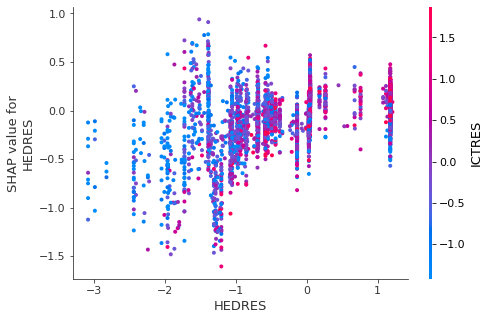

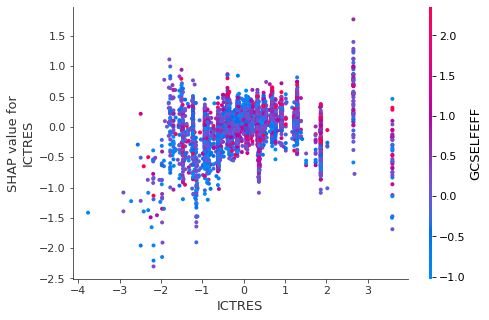

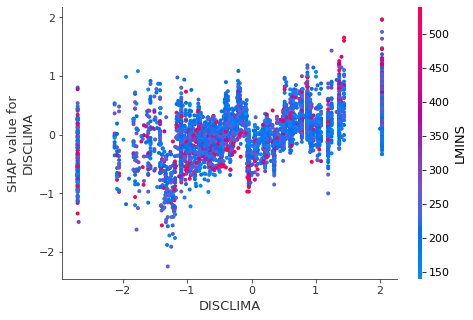

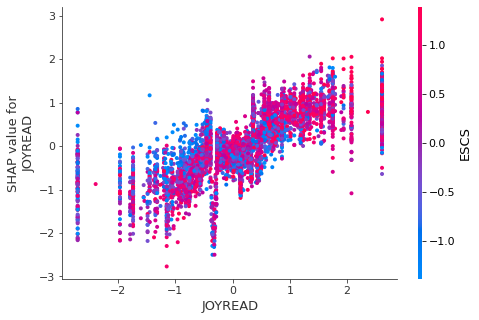

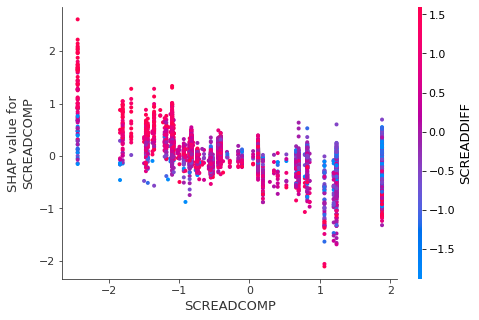

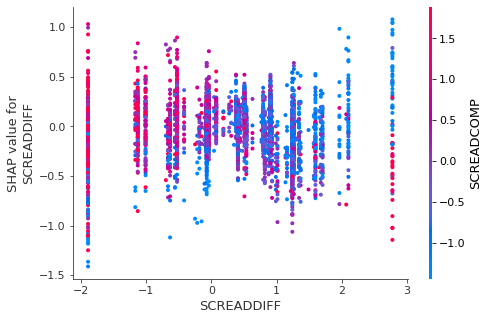

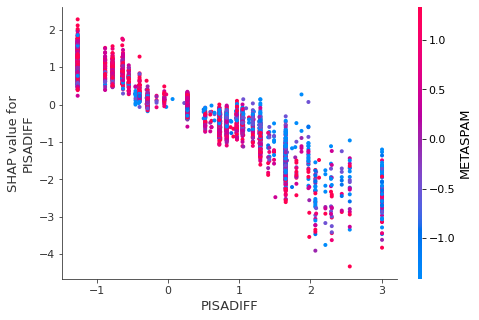

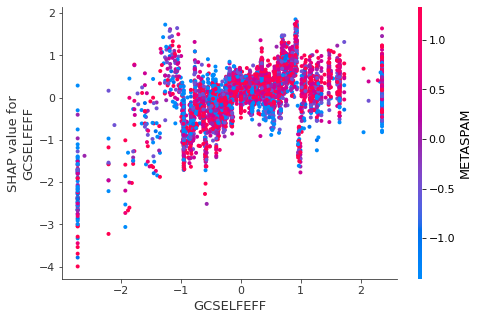

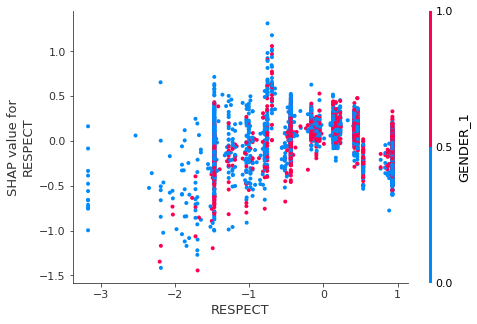

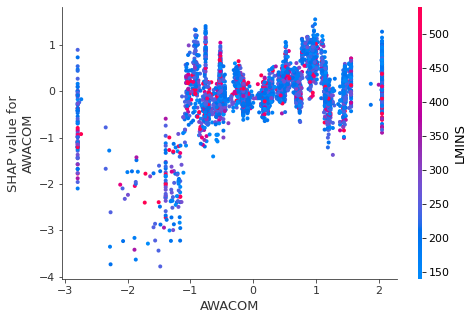

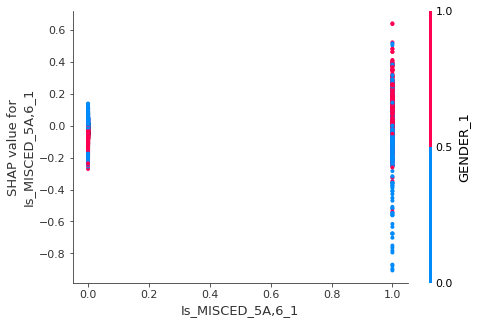

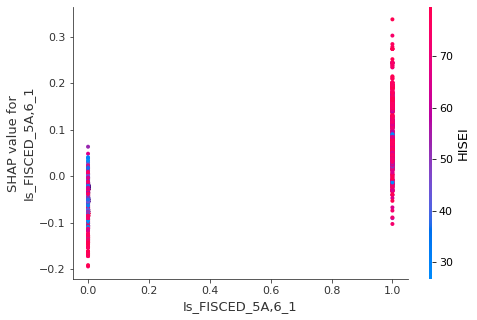

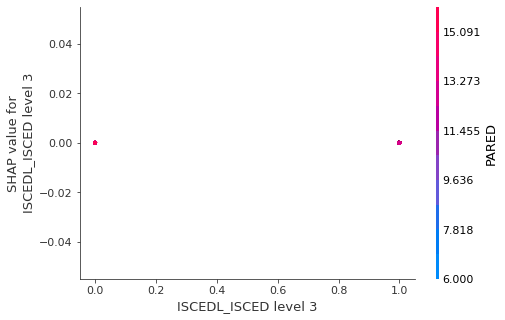

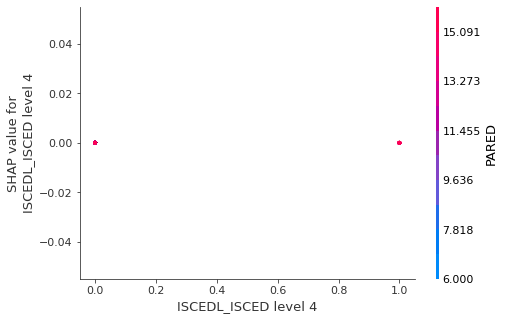

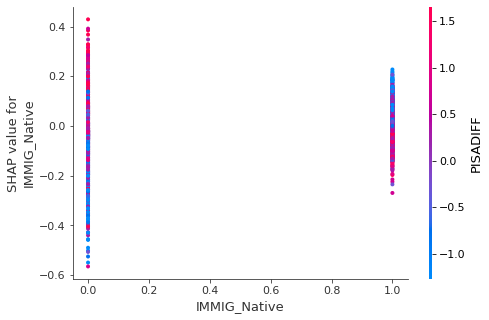

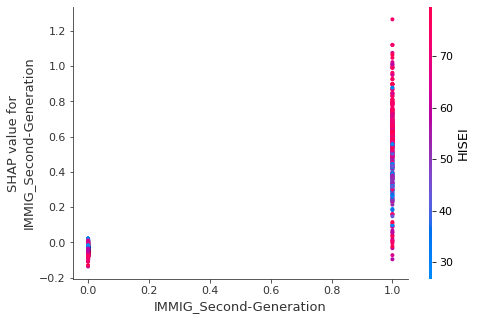

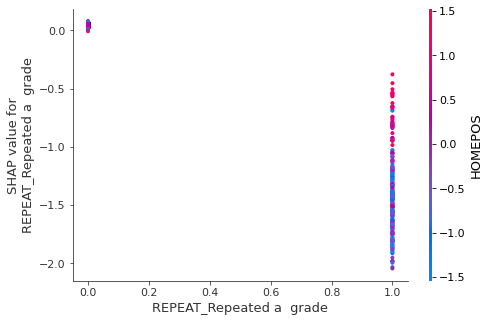

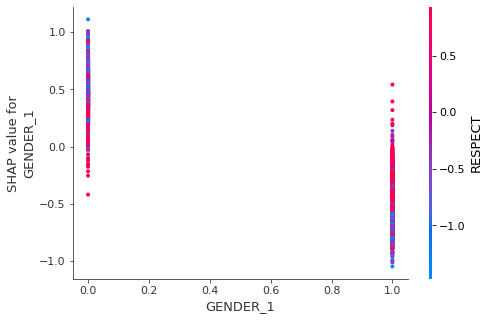

In [75]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)